In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc


In [2]:
# 读取数据
path = 'C:/Users/WXJ/OneDrive/Desktop/机器学习二分类/ex2data1.txt'
import pandas as pd

data = pd.read_csv(path, sep=',', names=["特征1", "特征2", "标签"])
data.head()  # 返回data中的前几行数据，默认是前5行。

,特征1,特征2,标签
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
x_data = data.drop(columns=["标签"])
y_data = data["标签"]

# 数据标准化
seta = pow(np.sum(x_data ** 2) / x_data.shape[0], 0.5)
miu = np.sum(x_data) / x_data.shape[0]
x = (x_data - miu) / seta
y = y_data
x.insert(0, 'Ones', 1)

D:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [4]:
# 定义 LogisticRegression 类
class LogisticRegression:
    def __init__(self):
        pass

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def computeCost(self, X, Y, W):
        m = X.shape[0]
        P = self.sigmoid(X @ W)
        loss = np.sum(-Y * np.log(P) - (1 - Y) * np.log(1 - P)) / m
        return loss, P

    def gradientDecent(self, W, X, Y, alpha):
        m = X.shape[0]
        error = self.sigmoid(X @ W)
        grad = (X.T @ (error - Y)) / m
        W -= alpha * grad
        return W

    def gradient_descent(self, X, Y, X_test, Y_test, alpha, iters):
        m, n = X.shape
        W = np.zeros((n, 1))
        loss_his = []
        loss_his_test = []
        W_his = []
        for i in range(iters):
            loss, P = self.computeCost(X, Y, W)
            loss_test, _ = self.computeCost(X_test, Y_test, W)
            loss_his_test.append(loss_test)
            loss_his.append(loss)
            W = self.gradientDecent(W, X, Y, alpha)
            W_his.append(W)
        return loss_his, loss_his_test, W_his, W

In [5]:
# 初始化 LogisticRegression 对象
model = LogisticRegression()

In [6]:
# 使用重复 K 折交叉验证数据划分法获得训练集和测试集
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=None)

In [8]:
# 存储所有折的结果
loss_his_all_train = []  # 存储训练集的损失历史
loss_his_all_test = []  # 存储测试集的损失历史
W_all = []

tprs = []
aucs = []
precisions = []
mean_fpr = np.linspace(0, 1, 100)
recalls = []
F1s = []


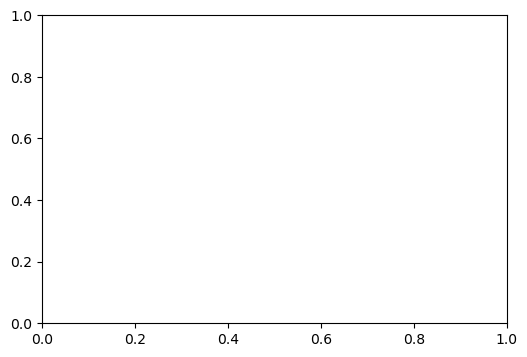

In [9]:
plt.subplots(figsize=(6, 4))
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = x_train.values
    Y_train = y_train.values.reshape(-1, 1)

    X_test = x_test.values
    Y_test = y_test.values.reshape(-1, 1)

    alpha = 0.1
    iters = 10000

    # 模型测试
    loss_his_train, loss_his_test, W_his, W = model.gradient_descent(X_train, Y_train, X_test, Y_test, alpha, iters)

    # 模型评价
    y_hat = X_test @ W
    p = model.sigmoid(y_hat)
    fpr, tpr, _ = roc_curve(Y_test, p)
    precision, recall, _ = precision_recall_curve(Y_test, p)

    # 保存结果
    loss_his_all_train.append(loss_his_train)
    loss_his_all_test.append(loss_his_test)
    W_all.append(W)

    precisions.append(precision)
    # precisions[-1][0] = 0.0
    recalls.append(recall)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[0][-1] = 0.0

    # 计算auc
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # 计算F1
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(p)):
        j = i - 1
        if (p[j] >= 0.5) and (Y_test[j] == 1):
            tp = tp + 1
        elif (p[j] < 0.5) and (Y_test[j] == 1):
            fn = fn + 1
        elif (p[j] >= 0.5) and (Y_test[j] == 0):
            fp = fp + 1
        elif (p[j] < 0.5) and (Y_test[j] == 0):
            tn = tn + 1
    precision_f1 = float(tp) / (tp + fp)
    recall_f1 = float(tp) / (tp + fn)
    F1 = 2 * precision_f1 * recall_f1 / (precision_f1 + recall_f1)
    F1s.append(F1)

In [10]:
# 计算平均值
loss_his_mean_train = np.mean(loss_his_all_train, axis=0)  # axis=0,表示压缩行去平均
loss_his_mean_test = np.mean(loss_his_all_test, axis=0)
W_mean = np.mean(W_all, axis=0)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr[0] = 0
mean_precision = np.mean(precisions, axis=0)
mean_recall = np.mean(recalls, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)  # 计算平均AUC值
mean_F1 = np.mean(F1s)

In [11]:
# 输出mean_AUC
print('mean_AUC=', mean_auc)
# 输出F1——score
print('F1_score = ', mean_F1)

mean_AUC= 0.9610185185185185
F1_score =  0.9059213009213009


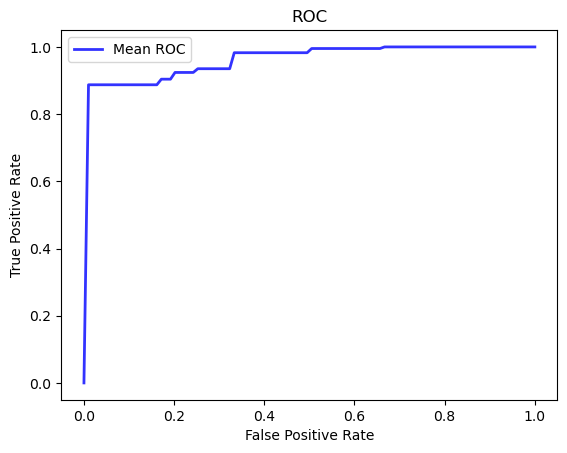

In [12]:
# 绘制ROC曲线
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC' % mean_auc, lw=2, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()

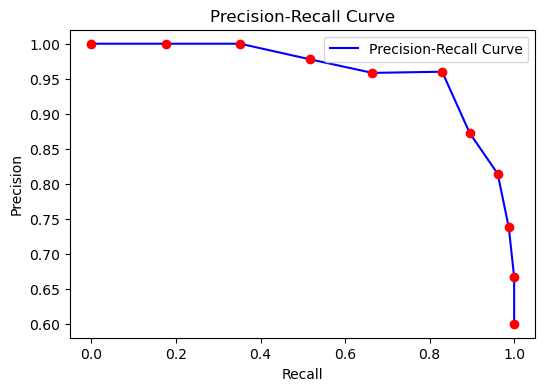

In [13]:
# 绘制PR曲线
plt.subplots(figsize=(6, 4))
plt.plot(mean_recall, mean_precision, color='b', label='Precision-Recall Curve')
plt.plot(mean_recall, mean_precision, 'ro')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

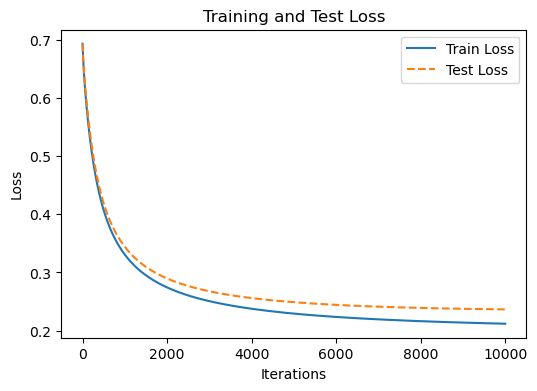

In [14]:
# 绘制训练曲线和测试曲线
plt.subplots(figsize=(6, 4))
plt.plot(np.arange(iters), loss_his_mean_train, label='Train Loss')
plt.plot(np.arange(iters), loss_his_mean_test, label='Test Loss', linestyle='--')

plt.title('Training and Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()